In [9]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# PyTorch for TabNet / DNN
import torch

In [10]:
!pip install pytorch-tabnet

In [11]:
df = pd.read_csv("/kaggle/input/health-risk-predictor-dataset/final_data.csv")

df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97297 entries, 0 to 97296
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 97297 non-null  int64  
 1   gender                              97297 non-null  object 
 2   ethnicity                           97297 non-null  object 
 3   education_level                     97297 non-null  object 
 4   income_level                        97297 non-null  object 
 5   employment_status                   97297 non-null  object 
 6   smoking_status                      97297 non-null  object 
 7   alcohol_consumption_per_week        97297 non-null  int64  
 8   physical_activity_minutes_per_week  97297 non-null  int64  
 9   diet_score                          97297 non-null  float64
 10  sleep_hours_per_day                 97297 non-null  float64
 11  screen_time_hours_per_day           97297

Age  alcohol_consumption_per_week  \
count  97297.000000                  97297.000000   
mean      50.192699                      2.004543   
std       15.492557                      1.418060   
min       19.000000                      0.000000   
25%       38.000000                      1.000000   
50%       51.000000                      2.000000   
75%       61.000000                      3.000000   
max       90.000000                     10.000000   

       physical_activity_minutes_per_week    diet_score  sleep_hours_per_day  \
count                        97297.000000  97297.000000         97297.000000   
mean                           118.942886      5.995214             6.997708   
std                             84.441920      1.780096             1.093726   
min                              0.000000      0.000000             3.000000   
25%                             57.000000      4.800000             6.300000   
50%                            100.000000      6.000000             7.000000   
75%                            160.000000      7.200000             7.700000   
max                            833.000000     10.000000            10.000000   

       screen_time_hours_per_day  family_history_diabetes  \
count               97297.000000             97297.000000   
mean                    5.997031                 0.219657   
std                     2.469805                 0.414017   
min                     0.500000                 0.000000   
25%                     4.300000                 0.000000   
50%                     6.000000                 0.000000   
75%                     7.700000                 0.000000   
max                    16.800000                 1.000000   

       hypertension_history  cardiovascular_history           bmi  ...  \
count          97297.000000            97297.000000  97297.000000  ...   
mean               0.250912                0.079067     25.615093  ...   
std                0.433540                0.269845      3.588387  ...   
min                0.000000                0.000000     15.000000  ...   
25%                0.000000                0.000000     23.200000  ...   
50%                0.000000                0.000000     25.600000  ...   
75%                1.000000                0.000000     28.000000  ...   
max                1.000000                1.000000     39.200000  ...   

       triglycerides  glucose_fasting  glucose_postprandial  insulin_level  \
count   97297.000000     97297.000000          97297.000000   97297.000000   
mean      121.466407       111.121792            160.014348       9.063591   
std        43.393422        13.590382             30.938915       4.956342   
min        30.000000        60.000000             70.000000       2.000000   
25%        91.000000       102.000000            139.000000       5.090000   
50%       121.000000       111.000000            160.000000       8.790000   
75%       151.000000       120.000000            181.000000      12.450000   
max       344.000000       172.000000            287.000000      32.220000   

              hba1c  diabetes_risk_score  hypertension_risk_score  \
count  97297.000000         97297.000000             97297.000000   
mean       6.520338            41.237414                41.137170   
std        0.813710            10.990720                12.755572   
min        4.000000             1.821211                 0.000000   
25%        5.970000            33.611350                32.136805   
50%        6.520000            40.773364                40.941950   
75%        7.070000            48.430041                49.911238   
max        9.800000            84.329497                92.102337   

       heart_disease_risk_score  obesity_risk_score  cholesterol_risk_score  
count              97297.000000        97297.000000            97297.000000  
mean                  32.063255           48.407241               26.075076  
std                   15.412755          

In [12]:
#Encoding :

# Smoking status: ordinal categorical 
df["smoking_status"] = df["smoking_status"].map({
    "Never": 0,
    "Former": 1,
    "Current": 2
})

# Education_level
education_map = {
    "No formal": 0,
    "Highschool": 1,
    "Graduate": 2,
    "Postgraduate": 3
}

df["education_level"] = df["education_level"].map(education_map)

# Income_level :
income_map = {
    "Low": 0,
    "Lower-Middle": 1,
    "Middle": 2,
    "Upper-Middle": 3,
    "High": 4
}
df["income_level"] = df["income_level"].map(income_map)

#--------------------------------------------------------------------------------------------------------

# Emplyement_status & Ethnicity
df = pd.get_dummies(
    df,
    columns=["employment_status", "ethnicity", "gender"],
    drop_first=False
)

In [13]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97297 entries, 0 to 97296
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 97297 non-null  int64  
 1   education_level                     97297 non-null  int64  
 2   income_level                        97297 non-null  int64  
 3   smoking_status                      97297 non-null  int64  
 4   alcohol_consumption_per_week        97297 non-null  int64  
 5   physical_activity_minutes_per_week  97297 non-null  int64  
 6   diet_score                          97297 non-null  float64
 7   sleep_hours_per_day                 97297 non-null  float64
 8   screen_time_hours_per_day           97297 non-null  float64
 9   family_history_diabetes             97297 non-null  int64  
 10  hypertension_history                97297 non-null  int64  
 11  cardiovascular_history              97297

Age  education_level  income_level  smoking_status  \
count  97297.000000     97297.000000  97297.000000    97297.000000   
mean      50.192699         1.598210      1.750691        0.602999   
std       15.492557         0.801376      1.086620        0.801313   
min       19.000000         0.000000      0.000000        0.000000   
25%       38.000000         1.000000      1.000000        0.000000   
50%       51.000000         2.000000      2.000000        0.000000   
75%       61.000000         2.000000      2.000000        1.000000   
max       90.000000         3.000000      4.000000        2.000000   

       alcohol_consumption_per_week  physical_activity_minutes_per_week  \
count                  97297.000000                        97297.000000   
mean                       2.004543                          118.942886   
std                        1.418060                           84.441920   
min                        0.000000                            0.000000   
25%                        1.000000                           57.000000   
50%                        2.000000                          100.000000   
75%                        3.000000                          160.000000   
max                       10.000000                          833.000000   

         diet_score  sleep_hours_per_day  screen_time_hours_per_day  \
count  97297.000000         97297.000000               97297.000000   
mean       5.995214             6.997708                   5.997031   
std        1.780096             1.093726                   2.469805   
min        0.000000             3.000000                   0.500000   
25%        4.800000             6.300000                   4.300000   
50%        6.000000             7.000000                   6.000000   
75%        7.200000             7.700000                   7.700000   
max       10.000000            10.000000                  16.800000   

       family_history_diabetes  ...  triglycerides  glucose_fasting  \
count             97297.000000  ...   97297.000000     97297.000000   
mean                  0.219657  ...     121.466407       111.121792   
std                   0.414017  ...      43.393422        13.590382   
min                   0.000000  ...      30.000000        60.000000   
25%                   0.000000  ...      91.000000       102.000000   
50%                   0.000000  ...     121.000000       111.000000   
75%                   0.000000  ...     151.000000       120.000000   
max                   1.000000  ...     344.000000       172.000000   

       glucose_postprandial  insulin_level         hba1c  diabetes_risk_score  \
count          97297.000000   97297.000000  97297.000000         97297.000000   
mean             160.014348       9.063591      6.520338            41.237414   
std               30.938915       4.956342      0.813710            10.990720   
min               70.000000       2.000000      4.000000             1.821211   
25%              139.000000       5.090000      5.970000            33.611350   
50%              160.000000       8.790000      6.520000            40.773364   
75%              181.000000      12.450000      7.070000            48.430041   
max              287.000000      32.220000      9.800000            84.329497   

       hypertension_risk_score  heart_disease_risk_score  obesity_risk_score  \
count             97297.000000              97297.000000        97297.000000   
mean                 41.137170                 32.063255           48.407241   
std                  12.755572                 15.412755           10.998884   
min                   0.000000                  0.000000           12.711686   
25%                  32.136805                 20.389335           40.898793   
50%                  40.941950                 30.793098           48.509658   
75%                  49.911238                 42.564698           55.928994   
max                  92.102337                 97.902483   

In [14]:
# Targets :
targets = [
    "diabetes_risk_score",
    "hypertension_risk_score",
    "heart_disease_risk_score",
    "obesity_risk_score",
    "cholesterol_risk_score"
]

# Features :
features = [col for col in df.columns if col not in targets]

x = df[features]
y = df[targets]
print(x.shape, y.shape)

(97297, 37) (97297, 5)


In [15]:
# Train / Test Split :
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)


In [16]:
# Feature Scaling :
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
!pip install pytorch-tabnet


In [18]:
# Train Multi-Output TabNet (Primary)

import torch
from pytorch_tabnet.tab_model import TabNetRegressor

tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    seed=42,
    verbose=10
)

tabnet.fit(
    X_train_scaled,
    y_train.values,
    eval_set=[(X_test_scaled, y_test.values)],
    eval_metric=["rmse"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0
)


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 422.41434| val_0_rmse: 8.93523 |  0:00:05s
epoch 10 | loss: 12.18381| val_0_rmse: 3.26468 |  0:00:52s
epoch 20 | loss: 10.02595| val_0_rmse: 2.87744 |  0:01:38s
epoch 30 | loss: 9.5846  | val_0_rmse: 2.84344 |  0:02:24s
epoch 40 | loss: 9.00662 | val_0_rmse: 2.81018 |  0:03:11s
epoch 50 | loss: 8.27827 | val_0_rmse: 2.65414 |  0:03:56s
epoch 60 | loss: 8.12751 | val_0_rmse: 2.64879 |  0:04:43s
epoch 70 | loss: 8.2307  | val_0_rmse: 2.74089 |  0:05:30s

Early stopping occurred at epoch 76 with best_epoch = 56 and best_val_0_rmse = 2.60712


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [19]:
# Evaluate Tabnet (Testing)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

tabnet_preds = tabnet.predict(X_test_scaled)

for i, target in enumerate(targets):
    mae = mean_absolute_error(y_test.iloc[:, i], tabnet_preds[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], tabnet_preds[:, i]))
    r2 = r2_score(y_test.iloc[:, i], tabnet_preds[:, i])

    print(f"{target}")
    print(f"  MAE  : {mae:.3f}")
    print(f"  RMSE : {rmse:.3f}")
    print(f"  R²   : {r2:.3f}\n")


diabetes_risk_score
  MAE  : 1.811
  RMSE : 2.269
  R²   : 0.957

hypertension_risk_score
  MAE  : 2.051
  RMSE : 2.569
  R²   : 0.959

heart_disease_risk_score
  MAE  : 3.297
  RMSE : 4.188
  R²   : 0.926

obesity_risk_score
  MAE  : 1.398
  RMSE : 1.760
  R²   : 0.975

cholesterol_risk_score
  MAE  : 1.004
  RMSE : 1.265
  R²   : 0.991



In [20]:
# Train XGBoost (5 Separate Models)

from xgboost import XGBRegressor

xgb_models = {}
xgb_preds = np.zeros_like(y_test.values)

for i, target in enumerate(targets):
    model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train[target])
    xgb_models[target] = model
    xgb_preds[:, i] = model.predict(X_test)

In [21]:
# Evaluate XGBoost
for i, target in enumerate(targets):
    mae = mean_absolute_error(y_test.iloc[:, i], xgb_preds[:, i])
    r2 = r2_score(y_test.iloc[:, i], xgb_preds[:, i])
    print(f"{target} → MAE: {mae:.3f}, R²: {r2:.3f}")

diabetes_risk_score → MAE: 1.661, R²: 0.964
hypertension_risk_score → MAE: 2.039, R²: 0.960
heart_disease_risk_score → MAE: 3.239, R²: 0.929
obesity_risk_score → MAE: 1.229, R²: 0.981
cholesterol_risk_score → MAE: 0.835, R²: 0.994


In [30]:
#Define Risk Binning 
import numpy as np
from sklearn.metrics import classification_report

def risk_to_class(y):
    """
    Convert risk score (0–100) to class:
    0 = Low, 1 = Medium, 2 = High
    """
    return np.where(
        y <= 33, 0,
        np.where(y <= 66, 1, 2)
    )


In [34]:
for target in targets:
    y_true = risk_to_class(y_test[target].values)
    y_pred = risk_to_class(xgb_models[target].predict(X_test))

    print(f"\n📊 XGBoost Classification Report — {target}")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["Low", "Medium", "High"]
    ))



📊 XGBoost Classification Report — diabetes_risk_score
              precision    recall  f1-score   support

         Low       0.91      0.89      0.90      4516
      Medium       0.96      0.97      0.97     14622
        High       0.88      0.76      0.81       322

    accuracy                           0.95     19460
   macro avg       0.92      0.87      0.89     19460
weighted avg       0.95      0.95      0.95     19460


📊 XGBoost Classification Report — hypertension_risk_score
              precision    recall  f1-score   support

         Low       0.91      0.90      0.90      5260
      Medium       0.95      0.96      0.96     13671
        High       0.85      0.78      0.82       529

    accuracy                           0.94     19460
   macro avg       0.91      0.88      0.89     19460
weighted avg       0.94      0.94      0.94     19460


📊 XGBoost Classification Report — heart_disease_risk_score
              precision    recall  f1-score   support

         

In [22]:
# FEATURE ABLATION TEST

lab_features = [
    "triglycerides",
    "glucose_fasting",
    "glucose_postprandial",
    "insulin_level",
    "hba1c"
]

ablation_features = [f for f in features if f not in lab_features]

X_ablation = df[ablation_features]
y_ablation = df[targets]

from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X_ablation, y_ablation, test_size=0.2, random_state=42)


from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

ablation_preds = np.zeros_like(y_te.values)

for i, target in enumerate(targets):
    model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_tr, y_tr[target])
    ablation_preds[:, i] = model.predict(X_te)


In [23]:
# Evaluation of ABLATION TEST

for i, target in enumerate(targets):
    mae = mean_absolute_error(y_te.iloc[:, i], ablation_preds[:, i])
    r2 = r2_score(y_te.iloc[:, i], ablation_preds[:, i])
    print(f"{target} (Ablation) → MAE: {mae:.3f}, R²: {r2:.3f}")


diabetes_risk_score (Ablation) → MAE: 3.175, R²: 0.869
hypertension_risk_score (Ablation) → MAE: 2.033, R²: 0.960
heart_disease_risk_score (Ablation) → MAE: 4.144, R²: 0.892
obesity_risk_score (Ablation) → MAE: 1.228, R²: 0.981
cholesterol_risk_score (Ablation) → MAE: 1.304, R²: 0.984


In [24]:
# K-FOLD VALIDATION (STABILITY)

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae = {t: [] for t in targets}

for train_idx, val_idx in kf.split(x):
    x_tr, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    for target in targets:
        model = XGBRegressor(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        model.fit(x_tr, y_tr[target])
        preds = model.predict(x_val)
        cv_mae[target].append(
            mean_absolute_error(y_val[target], preds)
        )


In [25]:
# Report CV Stability

for target in targets:
    print(
        f"{target} → CV MAE: {np.mean(cv_mae[target]):.3f} "
        f"(± {np.std(cv_mae[target]):.3f})"
    )


diabetes_risk_score → CV MAE: 1.645 (± 0.009)
hypertension_risk_score → CV MAE: 2.042 (± 0.004)
heart_disease_risk_score → CV MAE: 3.228 (± 0.016)
obesity_risk_score → CV MAE: 1.223 (± 0.004)
cholesterol_risk_score → CV MAE: 0.838 (± 0.005)


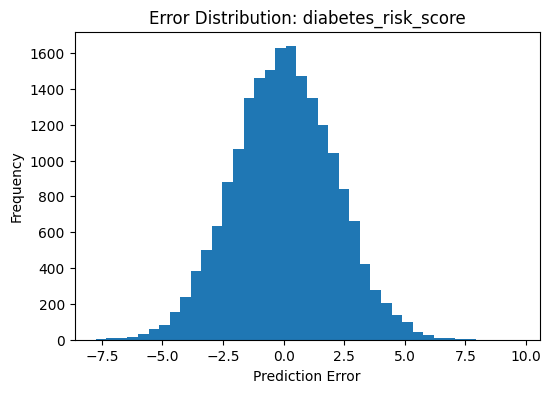

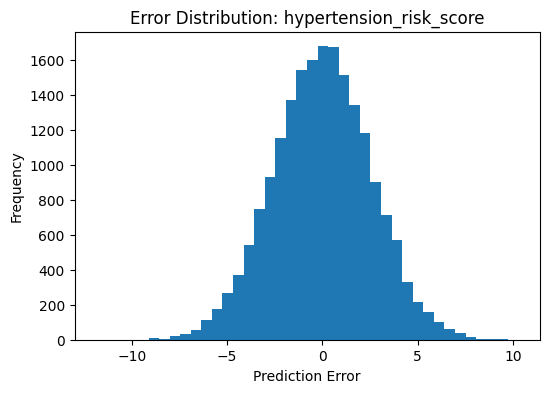

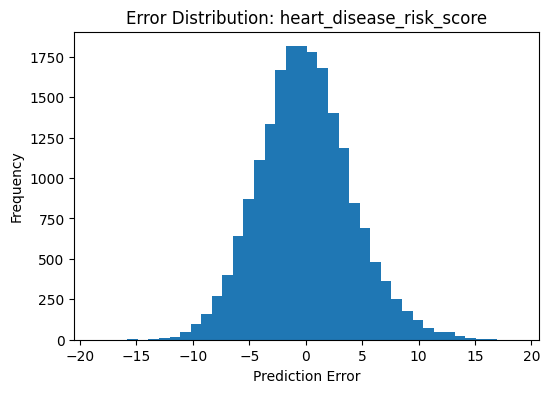

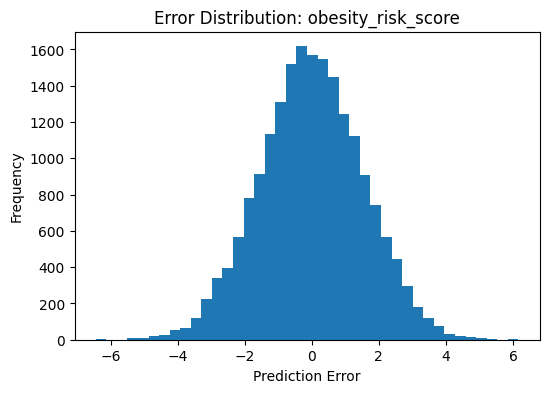

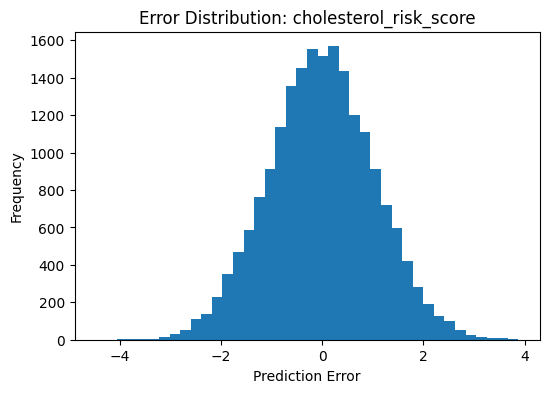

In [26]:
# ERROR Computing
errors = y_test.values - xgb_preds

# ERROR Plotting
import matplotlib.pyplot as plt

for i, target in enumerate(targets):
    plt.figure(figsize=(6,4))
    plt.hist(errors[:, i], bins=40)
    plt.title(f"Error Distribution: {target}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.show()


In [27]:
# Simple Confidence-Aware Ensemble
final_preds = 0.6 * tabnet_preds + 0.4 * xgb_preds

#Evaluate
for i, target in enumerate(targets):
    mae = mean_absolute_error(y_test.iloc[:, i], final_preds[:, i])
    r2 = r2_score(y_test.iloc[:, i], final_preds[:, i])
    print(f"{target} (Ensemble) → MAE: {mae:.3f}, R²: {r2:.3f}")

diabetes_risk_score (Ensemble) → MAE: 1.696, R²: 0.963
hypertension_risk_score (Ensemble) → MAE: 2.026, R²: 0.960
heart_disease_risk_score (Ensemble) → MAE: 3.246, R²: 0.929
obesity_risk_score (Ensemble) → MAE: 1.281, R²: 0.979
cholesterol_risk_score (Ensemble) → MAE: 0.881, R²: 0.993


In [28]:
# Save models
import joblib

joblib.dump(scaler, "scaler.pkl")
tabnet.save_model("tabnet_model")
joblib.dump(xgb_models, "xgb_models.pkl")

Successfully saved model at tabnet_model.zip


['xgb_models.pkl']

In [29]:
import joblib
xgb_models = joblib.load("xgb_models.pkl")

# Pick any model
model = list(xgb_models.values())[0]
print(model.feature_names_in_)


['Age' 'education_level' 'income_level' 'smoking_status'
 'alcohol_consumption_per_week' 'physical_activity_minutes_per_week'
 'diet_score' 'sleep_hours_per_day' 'screen_time_hours_per_day'
 'family_history_diabetes' 'hypertension_history' 'cardiovascular_history'
 'bmi' 'waist_to_hip_ratio' 'systolic_bp' 'diastolic_bp' 'heart_rate'
 'cholesterol_total' 'hdl_cholesterol' 'ldl_cholesterol' 'triglycerides'
 'glucose_fasting' 'glucose_postprandial' 'insulin_level' 'hba1c'
 'employment_status_Employed' 'employment_status_Retired'
 'employment_status_Student' 'employment_status_Unemployed'
 'ethnicity_Asian' 'ethnicity_Black' 'ethnicity_Hispanic'
 'ethnicity_Other' 'ethnicity_White' 'gender_Female' 'gender_Male'
 'gender_Other']


CLASSIFICATION REPORT